In [21]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

Extracting the Spectrogram for every Audio

In [22]:
audio_path = '../ML1020/music/T08-violin.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))
#<class 'numpy.ndarray'> <class 'int'>
print(x.shape, sr)
#(396688,) 22050

<class 'numpy.ndarray'> <class 'int'>
(110250,) 22050


In [23]:
librosa.load(audio_path, sr=44100)

(array([ 0.        ,  0.00015259,  0.00030518, ..., -0.1003418 ,
        -0.09783936, -0.09283447], dtype=float32), 44100)

In [24]:
librosa.load(audio_path, sr=None)

(array([ 0.        ,  0.00015259,  0.00030518, ..., -0.1003418 ,
        -0.09783936, -0.09283447], dtype=float32), 44100)

In [25]:
import IPython.display as ipd
ipd.Audio(audio_path)

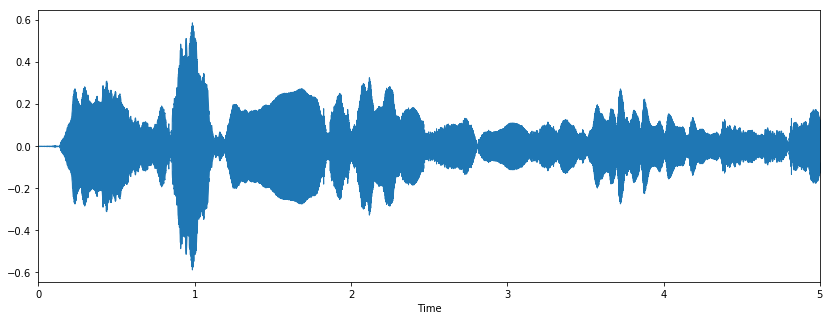

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

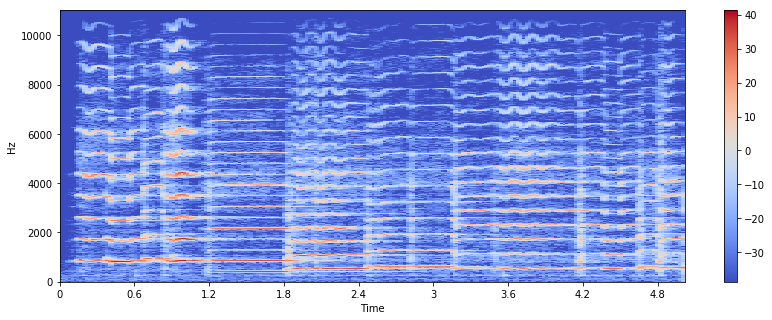

In [27]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

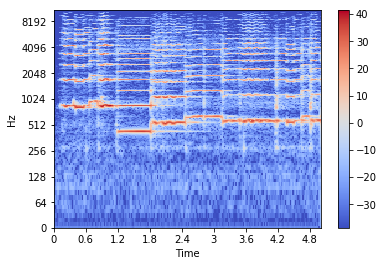

In [28]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [29]:
librosa.output.write_wav('example.wav', x, sr)

In [30]:
import numpy as np
sr = 22050 # sample rate
T = 5.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*220*t)# pure sine wave at 220 Hz


In [31]:
#Playing the audio
ipd.Audio(x, rate=sr) # load a NumPy array


In [32]:
#Saving the audio
librosa.output.write_wav('tone_220.wav', x, sr)


Feature extraction

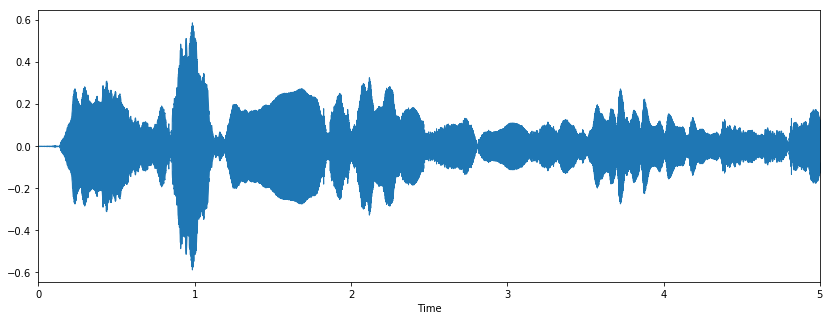

In [33]:
# Load the signal
x, sr = librosa.load('../ML1020/music/T08-violin.wav')
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)



## Zero Crossing Rate
The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

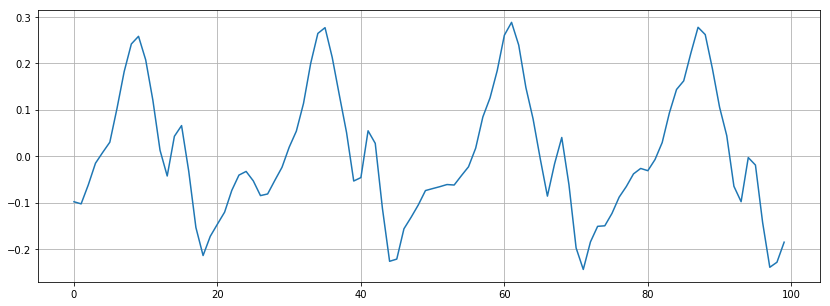

In [34]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

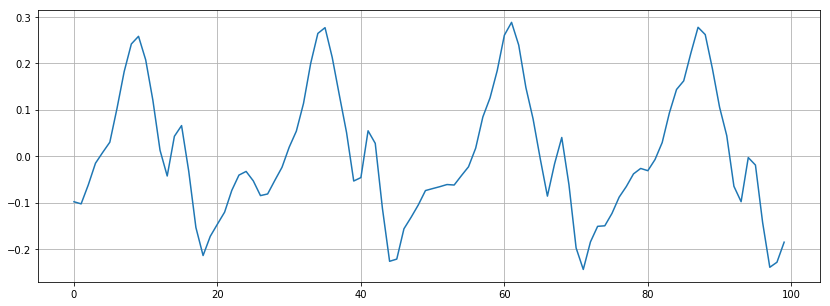

In [35]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

There appear to be 14 zero crossings. Let’s verify with librosa.

In [36]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

14


## Spectral Centroid
It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. Consider two songs, one from a blues genre and the other belonging to metal.

In [51]:
from sklearn import preprocessing
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)

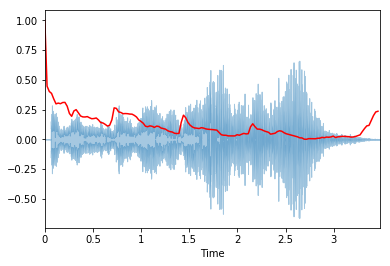

In [52]:
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

## Spectral Rolloff
It is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

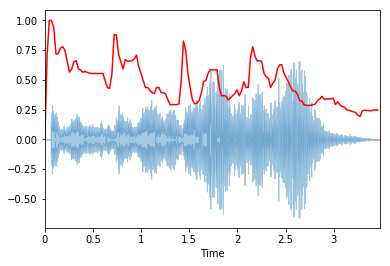

In [53]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

## Mel-Frequency Cepstral Coefficients
The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

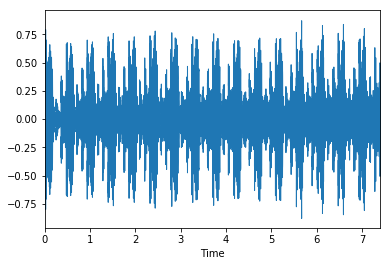

In [45]:
x, fs = librosa.load('../ML1020/music/simple_loop.wav')
librosa.display.waveplot(x, sr=sr)

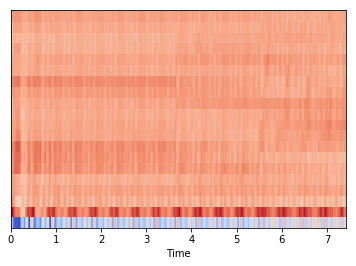

In [48]:
mfccs = librosa.feature.mfcc(x, sr=fs)
mfccs.shape
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

[ 1.01938660e-15 -3.49424425e-16  1.89329569e-16  2.05513071e-16
  1.19027045e-16  7.62190729e-16 -5.56851674e-16  1.08855801e-15
  3.09052679e-16  2.35269832e-16 -2.97915645e-16  5.63812320e-16
 -4.18334820e-16 -2.14231280e-15 -1.88633504e-16 -1.98726441e-15
  1.38864886e-16  3.48032296e-18 -2.49299884e-16  6.19149455e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


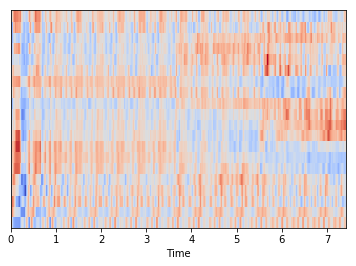

In [49]:
import sklearn
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## Chroma Frequencies
Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.

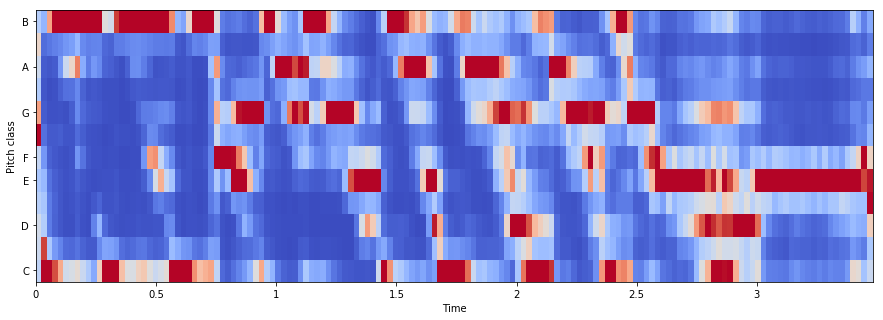

In [50]:
# Loadign the file
x, sr = librosa.load('../ML1020/music/simple_piano.wav')
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')